# A Simple CARMA Example

Preliminaries: we need to "activate" the Julia CARMA package, which we do here.  You will also need PyPlot and PyCall (plus the Python package Seaborn) if you want to make the plots look pretty in this notebook.

In [1]:
using Pkg
Pkg.activate("../")

using CARMA
using DelimitedFiles
using Ensemble
using HDF5
using PyPlot
using PyCall
using Statistics

@pyimport seaborn as sns

sns.set_context("notebook")
sns.set_style("ticks")
sns.set_palette("colorblind")

Activating environment at `~/Code/CARMA.jl/Project.toml`


┌ Info: Recompiling stale cache file /Users/wfarr/.julia/compiled/v1.2/CARMA/j3HtT.ji for CARMA [a07d8502-063d-4301-8ca6-fea2e825e4ed]
└ @ Base loading.jl:1240
┌ Info: Recompiling stale cache file /Users/wfarr/.julia/compiled/v1.2/PyPlot/oatAj.ji for PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1240
┌ Warning: `@pyimport foo` is deprecated in favor of `foo = pyimport("foo")`.
│   caller = _pywrap_pyimport(::PyObject) at PyCall.jl:407
└ @ PyCall /Users/wfarr/.julia/packages/PyCall/ttONZ/src/PyCall.jl:407


Now we load a simple data set (this is a time-series of RV observations of Aldebaran from [Farr, et al (2018)](https://ui.adsabs.harvard.edu/#abs/2018ApJ...865L..20F/abstract), which you can find [here](https://github.com/farr/Aldebaran/blob/master/data/song/tablesong.dat)).

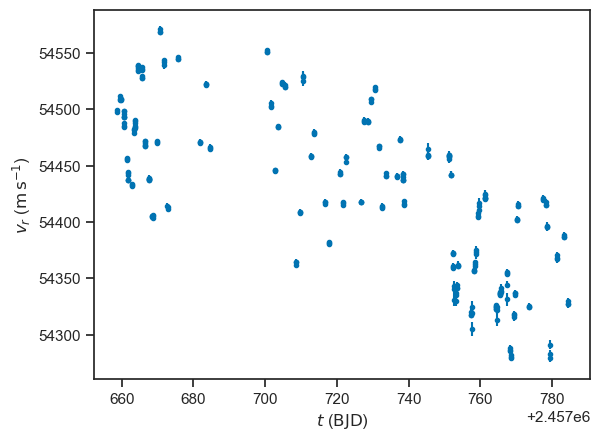

PyObject Text(32.900000000000006, 0.5, '$v_r$ ($\\mathrm{m} \\, \\mathrm{s}^{-1}$)')

In [2]:
data = readdlm("tablesong.dat")

errorbar(data[:,1], data[:,2], data[:,3], fmt=".")
xlabel(L"$t$ ($\mathrm{BJD}$)")
ylabel(L"$v_r$ ($\mathrm{m} \, \mathrm{s}^{-1}$)")

Now we construct a $\mathrm{CARMA}(3,2)$ model based on this data set, using some reasonable defaults for frequency / rate resolution:

In [3]:
p = 3
q = 2

cmodel = Kalman.CARMAKalmanPosterior(data[:,1], data[:,2], data[:,3], p, q);

To fit the model, we will use nested sampling from the ``Ensemble`` module, with the default priors and likelihood function (you can change the prior ranges for the rate parameters of the model from the defaults; see ``src/Kalman.jl`` for details).  We use 1024 live points in the evolving ensemble, and begin with 128 MCMC steps for each update to the live set (these are reasonable defaults).

In [4]:
nlive = 1024
nmcmc_initial = 128

nest = EnsembleNest.NestState(x -> Kalman.log_likelihood(cmodel, x),
                              x -> Kalman.log_prior(cmodel, x),
                              Kalman.init(cmodel, nlive),
                              nmcmc_initial);

Now we run the nested sampling, terminating when the change in log-evidence from continuing would be less than 0.01.  If you want to see the progress of the sampling, change the ``verbose`` argument.  If you want checkpointing (and automatic re-start), give a checkpoint file.

In [5]:
dlnZ_end = 0.01
EnsembleNest.run!(nest, dlnZ_end, verbose=false, ckpt_file=nothing)

UndefVarError: UndefVarError: warn not defined

This nested state can be saved to an HDF5 file if you want:

In [9]:
h5open("nested-state.h5", "w") do f
    write(f, nest)
end

-852.0335903383093

We can calculate the evidence for our $(3,2)$ model and its uncertainty.  (WARNING: the evidence is *very* prior-dependent, so you may want to explore alternative model-selection criteria---e.g. [Kelly, et al (2014)](https://ui.adsabs.harvard.edu/#abs/2014ApJ...788...33K/abstract) recommend DIC / AIC for this purpose.)

In [11]:
EnsembleNest.logZ(nest)

(-874.3637226178755, 0.006118485539104768)

Often, we want to calculate a posterior over our CARMA model; here we get samples of parameters (in an arbitrary, "unconstrained" space) from our posterior:

In [12]:
uc_postsamples, logls = EnsembleNest.postsample(nest);

It is convenient to convert these to more meaningful parameters:

In [13]:
posteriors = [Kalman.to_params(cmodel, uc_postsamples[:,j]) for j in 1:size(uc_postsamples, 2)];

This array corresponds to the structured parameters from ``Kalman.jl``.  For example, here is the posterior over the mean, then the standard deviation, and finally the errorbar scaling ($\nu$, defined by true uncertainty = $\nu$ times reported uncertainty):

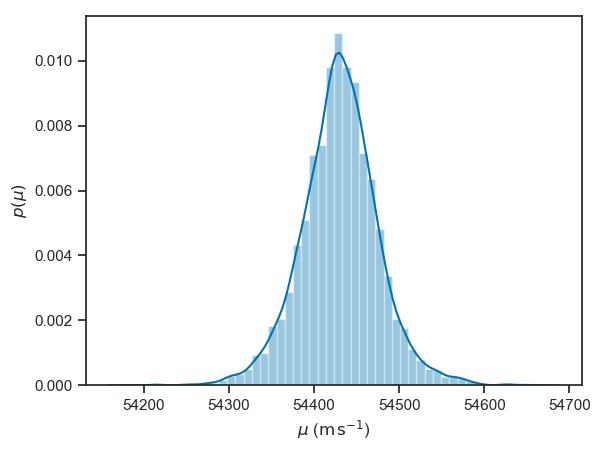

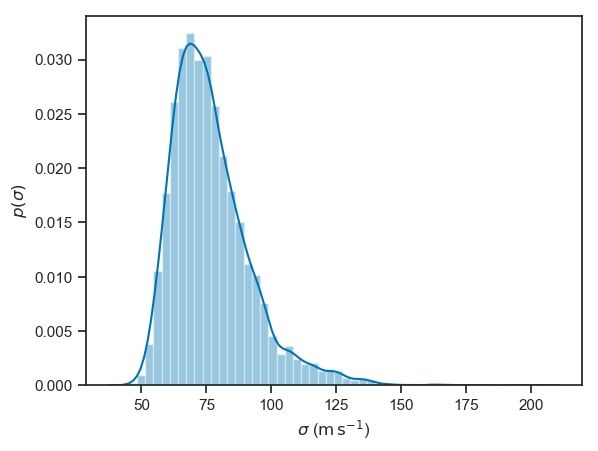

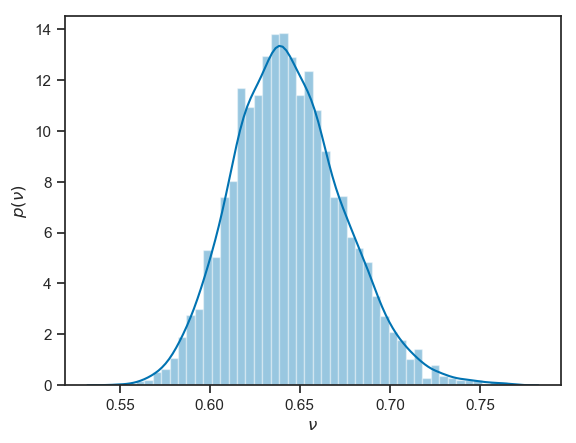

PyObject Text(29.0, 0.5, '$p(\\nu)$')

In [15]:
figure()
sns.distplot([p.mu for p in posteriors])
xlabel(L"$\mu$ ($\mathrm{m} \, \mathrm{s}^{-1}$)")
ylabel(L"$p(\mu)$")

figure()
sns.distplot([p.sigma for p in posteriors])
xlabel(L"$\sigma$ ($\mathrm{m} \, \mathrm{s}^{-1}$)")
ylabel(L"$p\left( \sigma \right)$")

figure()
sns.distplot([p.nu for p in posteriors])
xlabel(L"$\nu$")
ylabel(L"$p(\nu)$")

Often, we want to look at the posterior over the PSD.  First, we construct a frequency grid, then we produce one PSD for each posterior sample on that grid, and finally we plot the posterior median and 1-sigma band at each frequency in the grid.  We can clearly see the peak around $2 \, \mu\mathrm{Hz}$ reported in Farr, et al. (2018).

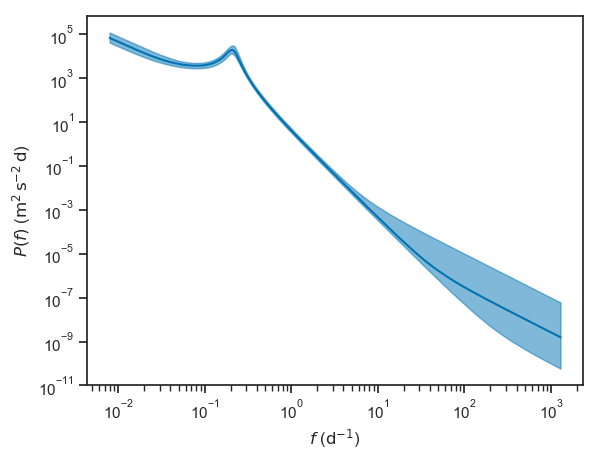

PyObject Text(32.9, 0.5, '$P(f)$ ($\\mathrm{m}^2 \\, \\mathrm{s}^{-2} \\, \\mathrm{d}$)')

In [25]:
nf = 1000
T = data[end,1] - data[1,1]
dt_min = minimum(diff(data[:,1]))

fmin = 1.0/T
fmax = 1.0/(2*dt_min) # Nyquist---can actually beat this by dithering times, but should be good enough for now

fs = exp.(collect(range(log(fmin), stop=log(fmax), length=nf)))
psds = zeros(nf, size(posteriors, 1))

for j in 1:size(posteriors,1)
    psds[:,j] = Kalman.psd(cmodel, posteriors[j], fs)
end

m = zeros(nf)
l = zeros(nf)
h = zeros(nf)

for i in 1:nf
    v = vec(psds[i,:])
    m[i] = median(v)
    l[i] = quantile(v, 0.16)
    h[i] = quantile(v, 0.84)
end

loglog(fs, m)
fill_between(fs, h, l, alpha=0.5, color=sns.color_palette()[1])

xlabel(L"$f$ ($\mathrm{d}^{-1}$)")
ylabel(L"$P(f)$ ($\mathrm{m}^2 \, \mathrm{s}^{-2} \, \mathrm{d}$)")

If we want to extract the frequency of the oscillatory modes, we can do that, too:

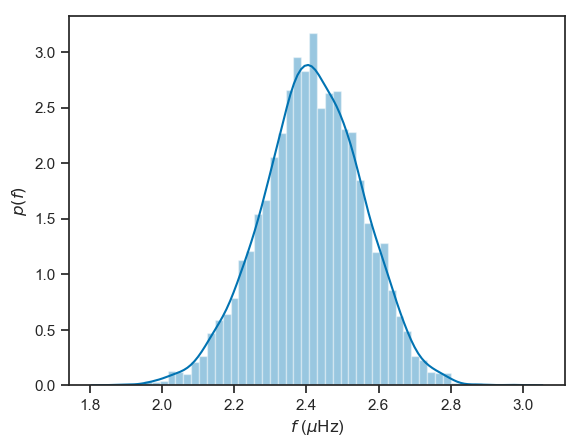

PyObject Text(29.0, 0.5, '$p(f)$')

In [32]:
# We report all frequencies (in positive/negative pairs, plus the zero frequency for the DRW term implied by (3,2))
# So, we need to extract only the positive frequency (if any)
allfreqs = [Kalman.frequencies(cmodel, p) for p in posteriors]
freqs = [maximum(f) for f in allfreqs]

# Time sampling is in days, but per day isn't a useful unit....
muHz = 1e-6*(3600.0*24.0) 

sns.distplot(freqs/muHz)
xlabel(L"$f$ ($\mu\mathrm{Hz}$)")
ylabel(L"$p(f)$")

## Where to Go From Here

* If you have several data sets with, say, different offsets and potentially different errorbar scaling, check out ``MultiSegmentCARMAKalmanPosterior``.  The call sequence is almost the same, but it takes *arrays* of times, samples, and uncertainties, and reports means and errorbar scalings in arrays (one per data set).
* If you have a Keplerian signal in your data, check out ``CARMAKepler.jl``, which allows simultaneous fits to the Keplerian and the CARMA model.
* If you just want a fast (much faster than CARMA(p,q)) correlated noise model, checkout the special AR(1) model in ``Kalman.jl``.  It is *almost* as fast as a white-noise model, but fits a correlation timescale, too!